# Analyzing KSTAR Activity Predictions for TNBC Tumors

## Load data

You will ideally need to download the KSTAR package (conda install -c naeglelab kstar/pip install kstar) for this analysis to be possible. You can work with the data using other packages for PCA/Clustering, but for plotting and probing of kstar networks, it will be easiest to use our built in functions.

In [1]:
## Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# load original phosphorylation data
phosphodata = pd.read_csv('pY_union_b.csv')

# Load kinase activity scores and false positive rate
activities = pd.read_excel('./analysis_results/kstar_results.xlsx', sheet_name = 'Kinase Activities', index_col = 0)
activities.columns = [str(col) for col in activities.columns]
fpr = pd.read_excel('./analysis_results/kstar_results.xlsx', sheet_name = 'False Positive Rate', index_col = 0)
fpr.columns = [str(col) for col in fpr.columns]

### Table of Contents
<a id="Table_Of_Contents"></a>

1. [Plotting full KSTAR activities](#full_dotplot) 
2. [Compare abundance of single phosphorylation site to predicted kinase activity](#phospho_quant)
3. [Identify phosphorylation sites that are most likely connected to kinases of interest](#substrate_influence)


## Plot full dotplot
<a id="full_dotplot"></a>

[Return to table of contents](#Table_Of_Contents)

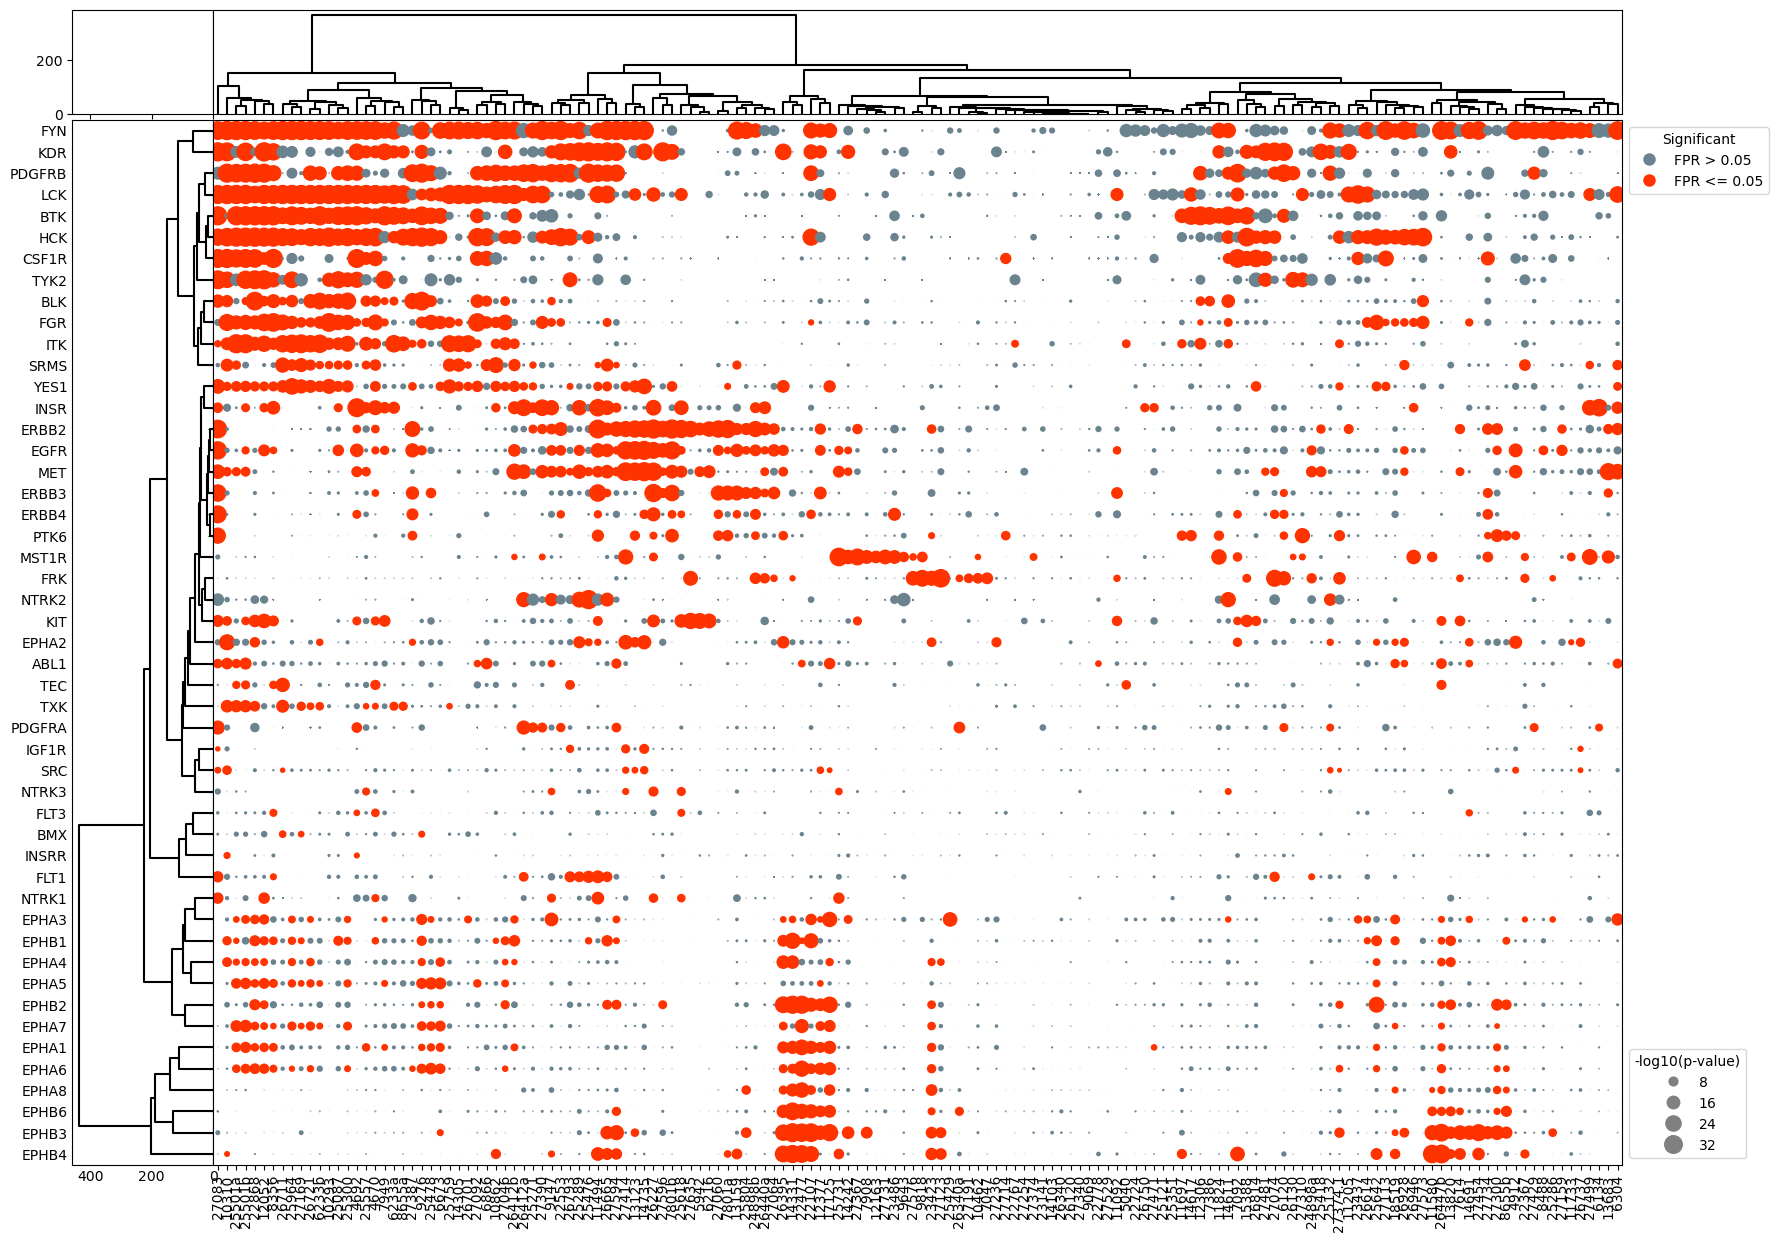

In [3]:
from kstar import plot

###edit here: if you want to plot specific kinases or samples, change values from None to list containing kinase/sample names###
kinases = None
#kinases = ['ERBB2', 'EGFR', 'MET']
samples = None
figsize = (20,15)
##############


#select samples/kinases
if samples is not None and kinases is not None:
    plt_act = activities.loc[kinases, samples]
    plt_fpr = fpr.loc[kinases, samples]
elif samples is not None:
    plt_act = activities[samples]
    plt_fpr = fpr[samples]
elif kinases is not None:
    plt_act = activities.loc[kinases]
    plt_fpr = fpr.loc[kinases]
else:
    plt_act = activities.copy()
    plt_fpr = fpr.copy()

#setup subplots fo rplot
fig, axes = plt.subplots(figsize = figsize,
        nrows = 2, ncols = 2,
        sharex = 'col',
        sharey = 'row',
        gridspec_kw = {
            'width_ratios': [0.1,1],
            'height_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0.01)

#instantiate the dotplot object
dots = plot.DotPlot(plt_act,
               plt_fpr,
               legend_title = '-log10(p-value)')

#remove kinases that are never significant in any sample
dots.drop_kinases_with_no_significance()

#cluster the kinases with hierarchical clustering, sort them accordingly,and add a dendrogram to the left of the dotplot
dots.cluster(orientation = 'left', ax = axes[1,0], method='ward')
#cluster the samples with hierarchical clustering, sort them accordingly, and add a dendrogram to the top of the dotplot
dots.cluster(orientation = 'top', ax = axes[0,1], method='ward')

#plot
dots.dotplot(axes[1,1])
plt.show()


## Compare single kinase activity to phosphorylation site quantification
<a id="phospho_quant"></a>

[Return to table of contents](#Table_Of_Contents)

If you want to know how a kinase's predicted activity correlates with a given phosphorylation site, use this code. For example, I can look to see how the ERBB2 active site (Y877) correlates with KSTAR predicted activity of ERBB2. We can then run quick correlation analyses to identify which kinases are most/least correlated with that phosphorylation site.

In [4]:
#### Edit Here ####
site = 'ERBB2_Y877'
kinase = 'ERBB2'
###################

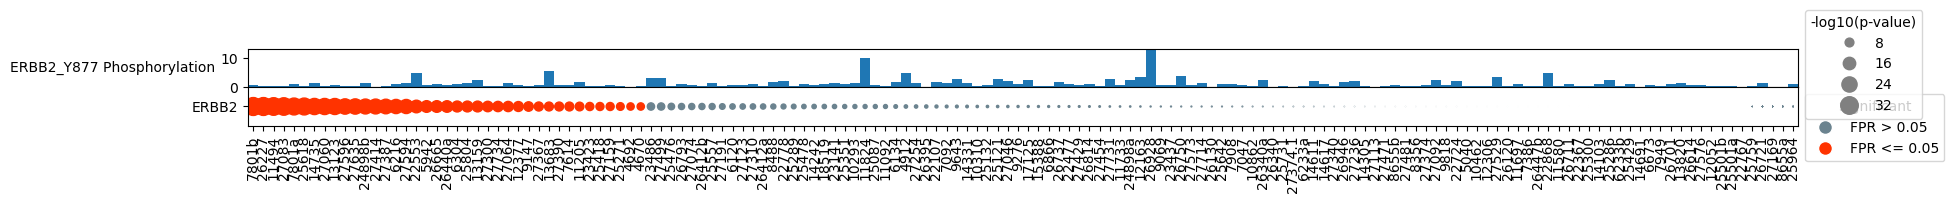

In [5]:
#obtain phosphoryaltion data for site of interest
plt_data = phosphodata[phosphodata['Label'] == site]
plt_data.index = plt_data['Label']
plt_data = plt_data.drop(['Gene','Accessions','Site','Motif', 'Label'], axis = 1)
plt_data = plt_data.squeeze()

#extract kinase activity of interest and sort by value
trim_activities = activities[activities.index == 'ERBB2']
trim_activities = trim_activities.sort_values(by = 'ERBB2', axis = 1, ascending = False)
plt_data = plt_data[activities.columns].squeeze()

#setup subplot
fig, axes = plt.subplots(figsize = (20, 1),
        nrows = 2,
        sharex = 'col',
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0.01)

#instantiate the dotplot object
dots = plot.DotPlot(trim_activities,
               fpr,
               legend_title = '-log10(p-value)')


dots.dotplot(axes[1])

#plot bar plot of site of interest
ticks = axes[1].get_xticks()
axes[0].bar(ticks, plt_data.values, width = 10)
axes[0].set_ylabel(f'{site} Phosphorylation', ha = 'right', va = 'center', rotation = 0)
plt.show()

Next, let's see if we can figure out what kinases are most correlated with our phosphorylation site of interest

In [7]:
#load in stats package
import scipy.stats as stats

corr_data = plt_data.dropna()
corr = {'Kinase':[],'r':[],'p':[]}
for kin in activities.index:
    r,p=stats.spearmanr(activities.loc[kin].values, corr_data.values)
    corr['Kinase'].append(kin)
    corr['r'].append(r)
    corr['p'].append(p)
    
pd.DataFrame(corr).sort_values('p', ascending = True)

,Kinase,r,p
17,EPHB3,0.321226,0.000055
21,ERBB3,0.303672,0.000143
6,EGFR,0.300029,0.000173
44,SRC,0.282571,0.000420
14,EPHA8,0.258203,0.001320
8,EPHA2,0.244719,0.002377
31,INSRR,-0.239572,0.002952
46,TEC,-0.220928,0.006235
37,MST1R,-0.219466,0.006595
16,EPHB2,0.214237,0.008041


### Extracting patient-specific kinase activity features

In [ ]:
#mask insignificant kinases with nan
fpr2 = fpr.copy()
fpr2[fpr2 > 0.05] = np.nan

#### Fraction of patients a kinase was found active in

In [ ]:
fpr2[~fpr2.isna()] = 1
fraction_active = (fpr2.T.sum()/fpr2.shape[1]).sort_values(ascending = False).reset_index()
fraction_active = fraction_active.rename({0:'Fraction of Patients with Predicted Activity'}, axis = 1)

#### Patient specific signatures of kinase activity

In [ ]:
#get the active kinases for each patient
signatures = {}
for patient in fpr2.columns:
    sig_list = fpr2[patient].dropna().index.values
    #signatures[patient.split(':')[1]] = ','.join(sig_list)
    signatures[patient] = ','.join(sig_list)


signatures = pd.DataFrame(signatures, index = ['Active Kinase Signatures']).T

In [ ]:
#get erbb2 positive patients
erbb2 = {}
for index, col in fpr.T.iterrows():
    #erbb2[col.name.split(':')[1]] = col['ERBB2'] <= 0.05
    erbb2[col.name] = col['ERBB2'] <= 0.05

erbb2 = pd.Series(erbb2)
erbb2.name = 'ERBB2 Positive'


#get egfr positive patients
egfr = {}
for index, col in fpr.T.iterrows():
    #egfr[col.name.split(':')[1]] = col['EGFR'] <= 0.05
    egfr[col.name] = col['EGFR'] <= 0.05

egfr = pd.Series(egfr)
egfr.name = 'EGFR Positive'


#get MET positive patients
met = {}
for index, col in fpr.T.iterrows():
    #met[col.name.split(':')[1]] = col['MET'] <= 0.05
    met[col.name] = col['MET'] <= 0.05
    
met = pd.Series(met)
met.name = 'MET Positive'

#get PDGFRB positive patients
PDGFRB = {}
for index, col in fpr.T.iterrows():
    #PDGFRB[col.name.split(':')[1]] = col['PDGFRB'] <= 0.05
    PDGFRB[col.name] = col['PDGFRB'] <= 0.05

PDGFRB = pd.Series(PDGFRB)
PDGFRB.name = 'PDGFRB Positive'


#get vegfr2/kdr positive patients
KDR = {}
for index, col in fpr.T.iterrows():
    #KDR[col.name.split(':')[1]] = col['KDR'] <= 0.05
    KDR[col.name] = col['KDR'] <= 0.05
KDR = pd.Series(KDR)
KDR.name = 'VEGFR2 Positive'


#get fgr positive patients
fgr = {}
for index, col in fpr.T.iterrows():
    #fgr[col.name.split(':')[1]] = col['FGR'] <= 0.05
    fgr[col.name] = col['FGR'] <= 0.05
fgr = pd.Series(fgr)
fgr.name = 'FGR Positive'

#immune infiltration markers
immune_markers = ['BLK', 'BTK', 'LCK','HCK', 'CSF1R', 'MST1R']
num_immune = {}
for index, col in fpr2.T.iterrows():
    tmp_immune = col[immune_markers].dropna()
    #num_immune[col.name.split(':')[1]] = tmp_immune.shape[0]
    num_immune[col.name] = tmp_immune.shape[0]
num_immune = pd.Series(num_immune)
num_immune.name = 'Number of Active Immune Markers'

In [ ]:
results = pd.concat([signatures, num_immune, erbb2, egfr, met, PDGFRB, KDR, fgr], axis = 1)
results.head()

#### Comparison of number of active immune kinases and GSEA

In [ ]:
#load kstar immune infiltration data
patient_signatures = pd.read_csv('./analysis_results/PatientSignatures.csv', index_col = 0)
go = pd.read_csv('./analysis_results/GO_Bio_2021.csv')

#check regulation of immune response
immune = go[go['Term'] == 'regulation of immune response ']
immune = immune.drop(['Term', 'GO IDs'], axis = 1)
nonimmune = immune[immune.isna()]
immune = immune.squeeze()
nonimmune = immune[immune.isna()]
nonimmune = nonimmune[[True if samp in patient_signatures.index.values else False for samp in nonimmune.index]]
immune = immune.dropna()
immune = immune[immune > 0]


plt.figure(figsize = (3,3))
plt.boxplot([patient_signatures.loc[immune.index, 'Number of Active Immune Markers'].values, patient_signatures.loc[nonimmune.index, 'Number of Active Immune Markers'].values], labels = ['Yes','No'])
plt.ylabel('Number of Active Immune Kinases')
plt.xlabel('Associated with Regulation of Immune Response')

## Obtain substrates that are important for prediction of a kinases activity
<a id="substrate_influence"></a>

[Return to table of contents](#Table_Of_Contents)

You will need to have our KSTAR networks downloaded, which can be found here: [KSTAR Networks](https://figshare.com/articles/dataset/NETWORKS/14944305).

Then configure the kstar environment to point to networks (only need to do this the first to run this notebook)

In [ ]:
from kstar import config

config.NETWORK_DIR, config.NETWORK_Y_PICKLE, config.NETWORK_ST_PICKLE = config.update_network_directory('./NETWORKS/NetworKIN/')

From there, you can now identify the most likely substrates of a kinase for a given patient by passing in which sites were used as evidence for the sample (need to load in 'evidence_binary.tsv')

In [11]:
from kstar.analysis import interactions
from kstar import config
import pickle

kinase = 'ERBB2'

#load necessary data
evidence_binary = pd.read_csv('tnbc_thresh1_random100_binarized_experiment.tsv', sep = '\t')
networks = pickle.load(open(config.NETWORK_Y_PICKLE, "rb" ) )

#get substrate influence
influence = interactions.getSubstrateInfluence_inExperiment(networks, evidence_binary, kinase)

Now that influence has been calculated, we can see, for an individual patient, which substrates are most connected to the kinase of interest (based on the number of KSTAR networks that kinase/substrate pair is found). A higher number indicates a higher likelihood of a true interaction.

In [12]:
influence['data:25618']

P07900_Y309    48.0
P35222_Y716    42.0
P04626_Y877    34.0
P08727_Y127    31.0
P12830_Y753    27.0
               ... 
Q1KMD3_Y222     1.0
P18124_Y195     1.0
P07355_Y109     1.0
Q9Y2W1_Y873     1.0
Q01130_Y23      1.0
Name: Number of Networks connected to ERBB2, Length: 84, dtype: float64